# Introduction

Given the process of getting to the airport and through security, people have an expectation for punctionality. We all know the feeling, walking up to your airport gate on time just to see that the flight has been delayed. It is extremely frustrating. What is even more frustrating is when the airline gives a new departure time, and then another, and then another. How does this happen? In this notebook I plan to investigate the different factors that affect flight delays and the problems of accurately predicting new departure times.

## Dataset 

The Dataset selected includes information on just over a million flights in 2008. This includes the following variables:

    1.  Year 2008 

    2.  Month 1-12 

    3.  DayofMonth 1-31 

    4.  DayOfWeek 1 (Monday) - 7 (Sunday)

    5.  DepTime actual departure time (local, hhmm)

    6.  CRSDepTime scheduled departure time (local, hhmm) 

    7.  ArrTime actual arrival time (local, hhmm)

    8.  CRSArrTime scheduled arrival time (local, hhmm)

    9.  UniqueCarrier unique carrier code

    10. FlightNum flight number

    11. TailNum plane tail number: aircraft registration, unique aircraft identifier

    12. ActualElapsedTime in minutes

    13. CRSElapsedTime in minutes

    14. AirTime in minutes

    15. ArrDelay arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).

    16. DepDelay departure delay, in minutes

    17. Origin origin IATA airport code

    18. Dest destination IATA airport code

    19. Distance in miles

    20. TaxiIn taxi in time, in minutes

    21. TaxiOut taxi out time in minutes

    22. Cancelled *was the flight cancelled

    23. CancellationCode reason for cancellation (A = carrier, B = weather, C = NAS, D = security)

    24. Diverted 1 = yes, 0 = no

    25. CarrierDelay in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.

    26. WeatherDelay in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.

    27. NASDelay in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.

    28. SecurityDelay in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

     29. LateAircraftDelay in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.



# Loading in the Data/Packages and Preparing it for Analysis 

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import r2_score

In [145]:
#Loading in the Dataset
flights = pd.read_csv("DelayedFlights.csv")

In [147]:
#Dataset Schema
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
Unnamed: 0           int64
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(11), object(5)
me

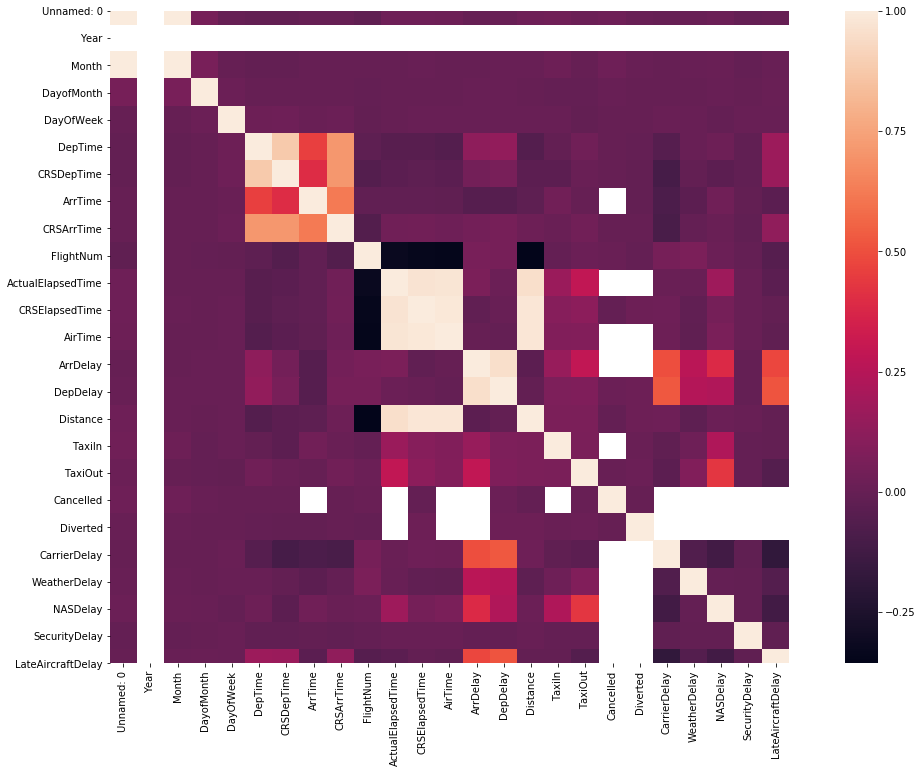

In [148]:
#Correlation Matrix
cm = flights.corr()
f, ax = plt.subplots(figsize=(20,12))
sns.heatmap(cm,vmax = 1, square = True)
plt.show()

As you can see, some of the variables are extremely correlated for obvious reasons. The variables related to time have the highest correlation. For example, a flight's arrival is highly dependent on when it actually departs from the gate. You can see some negative values in this column, showing that airlines will give themselves a little extra room for error. 

For the purpose of this analysis, I will focus mainly on departure delay. The variables that are most correlated to departure delay (other than arrival delay) include: Late Aircraft Delay, Security Delay, NAS Delay, and Carrier Delay.

In [149]:
#Creating New Date Variable
flights['Date'] = pd.to_datetime(flights.Year*10000 + flights.Month*100 + flights.DayofMonth, format = '%Y%m%d')

In [150]:
#Dropping Variables from the Table
flights = flights.drop(["Unnamed: 0","DayofMonth",'Year','FlightNum','TailNum'], axis = 1)


# Exploratory Data Analysis

## Airline Performance

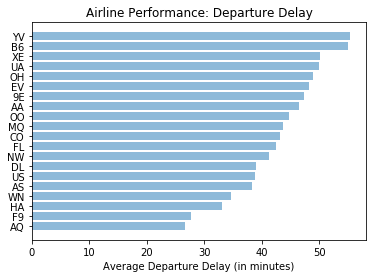

In [151]:
#Average Dep Delay by Airline
airlineAvgDelay = flights.groupby('UniqueCarrier').agg({'DepDelay':'mean','ArrDelay':'mean'})
airlineAvgDelay.reset_index(inplace = True)
airlineAvgDelay = airlineAvgDelay.sort_values(by = ['DepDelay'])
plt.barh(airlineAvgDelay.UniqueCarrier,airlineAvgDelay.DepDelay,align = 'center',alpha = .5)
plt.xlabel('Average Departure Delay (in minutes)')
plt.title("Airline Performance: Departure Delay")
plt.show()


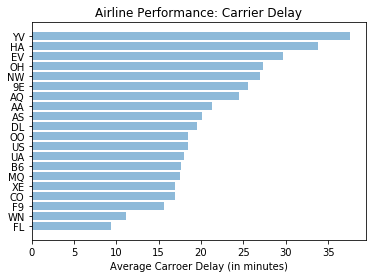

In [152]:
#Average Carrier Delay by Airline
airlineAvgCDelay = flights.groupby('UniqueCarrier').agg({'CarrierDelay':'mean'})
airlineAvgCDelay.reset_index(inplace = True)
airlineAvgCDelay = airlineAvgCDelay.sort_values(by = ['CarrierDelay'])
plt.barh(airlineAvgCDelay.UniqueCarrier,airlineAvgCDelay.CarrierDelay,align = 'center',alpha = .5)
plt.xlabel('Average Carroer Delay (in minutes)')
plt.title("Airline Performance: Carrier Delay")
plt.show()



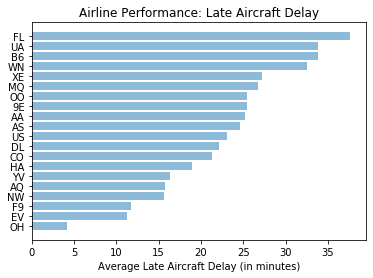

In [153]:
#Average Late Airctaft Delay by Airline
airlineAvgLADelay = flights.groupby('UniqueCarrier').agg({'LateAircraftDelay':'mean'})
airlineAvgLADelay.reset_index(inplace = True)
airlineAvgLADelay = airlineAvgLADelay.sort_values(by = ['LateAircraftDelay'])
plt.barh(airlineAvgLADelay.UniqueCarrier,airlineAvgLADelay.LateAircraftDelay,align = 'center',alpha = .5)
plt.xlabel('Average Late Aircraft Delay (in minutes)')
plt.title("Airline Performance: Late Aircraft Delay")
plt.show()

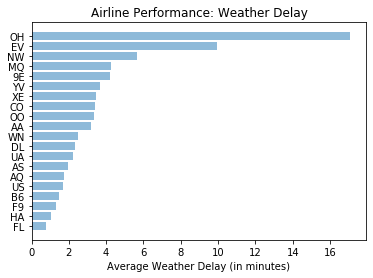

In [154]:
#Average Weather Delay by Airline
airlineAvgWDelay = flights.groupby('UniqueCarrier').agg({'WeatherDelay':'mean'})
airlineAvgWDelay.reset_index(inplace = True)
airlineAvgWDelay = airlineAvgWDelay.sort_values(by = ['WeatherDelay'])
plt.barh(airlineAvgWDelay.UniqueCarrier,airlineAvgWDelay.WeatherDelay,align = 'center',alpha = .5)
plt.xlabel('Average Weather Delay (in minutes)')
plt.title("Airline Performance: Weather Delay")
plt.show()

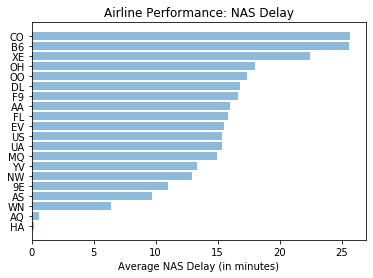

In [155]:
#Average NAS Delay by Airline
airlineAvgNDelay = flights.groupby('UniqueCarrier').agg({'NASDelay':'mean'})
airlineAvgNDelay.reset_index(inplace = True)
airlineAvgNDelay = airlineAvgNDelay.sort_values(by = ['NASDelay'])
plt.barh(airlineAvgNDelay.UniqueCarrier,airlineAvgNDelay.NASDelay,align = 'center',alpha = .5)
plt.xlabel('Average NAS Delay (in minutes)')
plt.title("Airline Performance: NAS Delay")
plt.show()

As you can see, different airlines experience different combinations of delays. For example, B6 (Jet Blue) has relatively low weather and carrier delay but has relatively high NAS and late aircraft delay. Overally, the airlines with the best performance overall include AQ (Aloha Air), F9 (Frontier Airlines), and HA (Hawaiian Air). The airlines with the relatively worst performance include YV (Mesa Airlines), B6 (Jetblue Airlines), and XE (Express Jet).

## Timing Effect

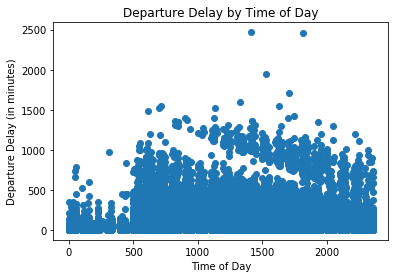

In [156]:
#Time of Day
plt.scatter(flights.CRSDepTime, flights.DepDelay)
plt.ylabel('Departure Delay (in minutes)')
plt.xlabel('Time of Day')
plt.title('Departure Delay by Time of Day')
plt.show()


As shown above, flights that take place earlier in the day have a less of a chance of being delayed. This is due to the fact that once a flight is delayed, any flight using that same plane that day will very likely experience that same delay. If you want to book a flight that is on time, I suggest booking the earliest one possible.

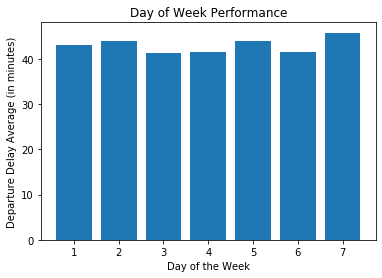

In [157]:
#Day of Week
dayOfWeekAvgDelay = flights.groupby("DayOfWeek").agg({"DepDelay":'mean',"DepTime":'count'})
dayOfWeekAvgDelay.reset_index(inplace = True)
plt.bar(dayOfWeekAvgDelay.DayOfWeek,dayOfWeekAvgDelay.DepDelay)
plt.title("Day of Week Performance")
plt.ylabel("Departure Delay Average (in minutes)")
plt.xlabel("Day of the Week")
plt.show()


While flights towards the end of the week have slightly above average delayss, there seems to be little difference between the day of the week and on time performance.

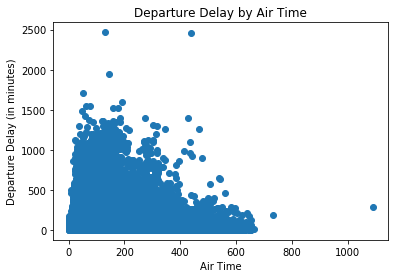

In [158]:
#Air Time Compared to Delay
plt.scatter(flights.AirTime, flights.DepDelay)
plt.ylabel('Departure Delay (in minutes)')
plt.xlabel('Air Time')
plt.title('Departure Delay by Air Time')
plt.show()



Longer flights tend to have less delay. However, this could simply because there are significantly less flights of this nature. In addition, longer flights could be on longer flight routes therefore less flights can take place in a day, less flights in the day means less room for error

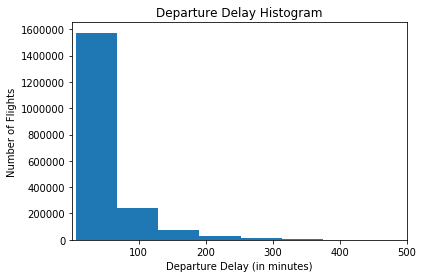

In [159]:
plt.hist(flights.DepDelay, bins = 40)
plt.xlim(1,500)
plt.title("Departure Delay Histogram")
plt.ylabel("Number of Flights")
plt.xlabel('Departure Delay (in minutes)')
plt.show()

A grand majority of flight delays are very small if anything. There is however a large number of flights that are delayed within a period of 1-2 hours.

# Modeling and Prediction

There are obviously many reasons that cause flight delays that are not included in this dataset. Instead on focusing on accurate predicitons, this section of analysis intends to investigate the difference in estimating a new departure time based on the information provided. For example, airlines might let their passengers know that there is a delay as soon as they get news that a previous flight has been delayed or weather conditions are present. However, the full extent of the delay cannot be known until that flight takes off or the weather pattern becomes more predictable. Airlines must provide their passengers with a new departure time, which as mentioned before is often incorrect. Through this section I plan to example the differences between predicting total delay in two scenarios:
    1. The full extent of the delays are known
    2. There is known to be a delay but the full extent is not yet known

## Data Prep for Prediction 

In [181]:
#Taking only the Non-Cancelled Flights and Dropping unwatned variables
depPrediction = flights.loc[flights['Cancelled']==0]

depPrediction = depPrediction.drop(['Cancelled','ArrTime','CRSArrTime','ActualElapsedTime',
                                    'CancellationCode','Diverted','Dest','CRSElapsedTime','TaxiIn','TaxiOut',
                                   'Date','Distance','DepTime','ArrDelay','Origin'], axis = 1)


In [185]:
#Fill NA values for flights with no delays (Therefore the values should be 0)
values = {'CarrierDelay':0,'WeatherDelay':0,'NASDelay':0,'SecurityDelay':0,'LateAircraftDelay':0,'AirTime':depPrediction.AirTime.mean()}
depPrediction = depPrediction.fillna(value = values)


In [186]:
#Check for Null Values
depPrediction.isnull().sum()

Month                0
DayOfWeek            0
CRSDepTime           0
UniqueCarrier        0
AirTime              0
DepDelay             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [187]:
#Using One Hot Encoder on Unique Airline Codes
enc = OneHotEncoder(handle_unknown = 'ignore')
enc_df = pd.DataFrame(enc.fit_transform(depPrediction[['UniqueCarrier']]).toarray())

depPrediction = depPrediction.join(enc_df)
depPrediction = depPrediction.fillna(0)

In [188]:
#Separate Data into X & Y Varables
y = depPrediction.DepDelay
X = depPrediction.drop('DepDelay', axis = 1)


In [189]:
#Unique Carrier is no longer needed
X = X.drop('UniqueCarrier',axis = 1)
X =X.fillna(0)

## Predicting Length with All Delay Components Known

In [190]:
#Test Train Split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size = .2, random_state = 0)

In [191]:
#Check for Null Values one more time
X.isnull().sum()

Month                0
DayOfWeek            0
CRSDepTime           0
AirTime              0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
0                    0
1                    0
2                    0
3                    0
4                    0
5                    0
6                    0
7                    0
8                    0
9                    0
10                   0
11                   0
12                   0
13                   0
14                   0
15                   0
16                   0
17                   0
18                   0
19                   0
dtype: int64

In [192]:
#Build and Fit the model
regressor = LinearRegression()
regressor.fit(X_train,y_train)

#Make Predictions
y_pred = regressor.predict(X_test)

In [193]:
#Short glimpse of predicted and actual values
pd.DataFrame({'Actual':y_test,'Predicted':y_pred}).head(10)

,Actual,Predicted
1209367,57.0,44.157577
1780071,9.0,42.761356
1184957,29.0,34.057811
1465526,31.0,34.684081
271673,9.0,8.488608
1767332,16.0,8.959394
1414268,263.0,242.221582
729594,37.0,33.776217
1739725,33.0,28.627402
639639,11.0,21.776669


In [194]:
#Model Results
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('R Squared Value:', r2_score(y_test,y_pred))

Mean Absolute Error: 9.722807307847555
Mean Squared Error: 243.1334524676267
Root Mean Squared Error: 15.592737170478655
R Squared Value: 0.9148113216217795


To no surprise, this model is pretty accurate. The adjusted timing of the flight can be estimated with high certainty once the extent of the delays are known.

## New Departure Time with Limited Info 

In [195]:
#Creating Binary Variables to Indicate There is a Delay
X2 = X
X2.CarrierDelayBin = 0
X2.loc[X2['CarrierDelay']>0,'CarrierDelayBin']= 1
X2.WeatherDelayBin = 0
X2.loc[X2['WeatherDelay']>0,'WeatherDelayBin']= 1
X2.NASDelayBin = 0
X2.loc[X2['NASDelay']>0,'NASDelayBin']= 1
X2.SecurityDelay = 0
X2.loc[X2['SecurityDelay']>0,'SecurityDelayBin']= 1
X2.LateAircraftDelay = 0
X2.loc[X2['LateAircraftDelay']>0,'LateAircraftDelayBin']= 1

In [196]:
#Remove the original variables
X2 = X2.fillna(0)
X2 = X2.drop(['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'],axis = 1)
X2.isna().sum()

Month                   0
DayOfWeek               0
CRSDepTime              0
AirTime                 0
0                       0
1                       0
2                       0
3                       0
4                       0
5                       0
6                       0
7                       0
8                       0
9                       0
10                      0
11                      0
12                      0
13                      0
14                      0
15                      0
16                      0
17                      0
18                      0
19                      0
CarrierDelayBin         0
WeatherDelayBin         0
NASDelayBin             0
SecurityDelayBin        0
LateAircraftDelayBin    0
dtype: int64

In [197]:
#Train/Test Split
y2 = y
X_train2, X_test2, y_train2, y_test2= train_test_split(X2,y2, test_size = .2, random_state = 0)
#Fit the Model
regressor = LinearRegression()
regressor.fit(X_train2,y_train2)
#Make Predictions
y_pred2 = regressor.predict(X_test2)

In [198]:
#Results
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test2,y_pred2))
print('Mean Squared Error:',metrics.mean_squared_error(y_test2,y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test2,y_pred2)))
print('R Squared:', r2_score(y_test2,y_pred2))

Mean Absolute Error: 31.205659578418214
Mean Squared Error: 2619.9740739264153
Root Mean Squared Error: 51.18568231377223
R Squared: 0.08201801735731218


In this case, we see an extremely inaccurate model. This shows that is nearly impossible to predict a new departure time without sufficient information on the delay. While airlines probably have access to massive amounts of other data that could help with prediction, passengers should still always be skeptical of the first new estimate of departure.